In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn
import random

sys.path.append("../functions")

from Fitting import *
from Utils import *
from Plotting import *
from Forward import *
from Backward import *

%matplotlib inline


# 1. Read Data

In [2]:
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "hc")
hv_induction_data =  preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "lc1")
subjects = lv_induction_data["sub"].unique()
data_list = [lv_induction_data, hv_induction_data]
data_list_names = ["lv_induction", "hv_induction"]

# 2. Fitting

In [3]:
n_fitting = 120
n_threads = 100

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
forward_dfs = []

for data in data_list:
    forward_res = fit_for_all_subjects_parallel(params_ranges, n_threads, n_fitting, subjects, data, forward_fitting, True)
    forward_df = make_df_after_fitting(forward_res, ["alpha", "beta", "lbound", "bound_range"], subjects)
    forward_df["hbound"] = (5 - forward_df["lbound"]) * forward_df["bound_range"] + forward_df["lbound"]
    forward_dfs.append(forward_df)


In [4]:
backward_dfs = []
for data in data_list:
    backward_res = fit_for_all_subjects_parallel(params_ranges, n_threads, n_fitting, subjects, data, fit_model_backward, True)
    backward_df = make_df_after_fitting(backward_res, ["alpha", "beta", "lbound", "bound_range"], subjects)
    backward_df["hbound"] = (5 - backward_df["lbound"]) * backward_df["bound_range"] + backward_df["lbound"]
    backward_dfs.append(backward_df)

## Supp Figure 7

In [5]:
back_param_df = merge_result_df(backward_dfs, data_list_names, 200, subjects)
back_param_df["bound_mean"] = (back_param_df["hbound"] + back_param_df["lbound"])/2


In [6]:
back_param_df.groupby("model")[["x_idx"]].mean()["x_idx"].to_numpy()[::-1]

array([ 27.5, 227.5])

Statistics for lv_induction and hv_induction =501.0, p=6.661e-01
mean lv_induction = 2.15
mean hv_induction = 2.06
Statistics for lv_induction and hv_induction =527.0, p=1.401e-01
mean lv_induction = 4.51
mean hv_induction = 4.42
Statistics for lv_induction and hv_induction =595.0, p=2.041e-01
mean lv_induction = 3.33
mean hv_induction = 3.24


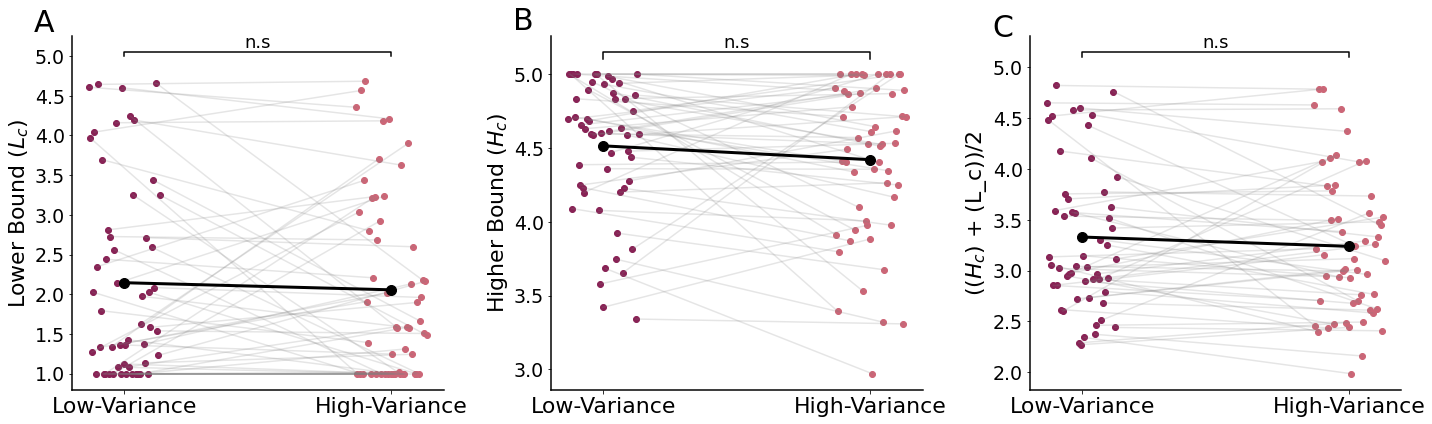

In [7]:
plt.figure(figsize=(20, 6))

color_dict["lv_induction"] = "#882255"
color_dict["hv_induction"] = "#CC6677"

xticks_labels = ["Low-Variance", "High-Variance"]
gr_xticks_ls = back_param_df.groupby("model")[["x_idx"]].mean()["x_idx"].to_numpy()[::-1]

plt.subplot(1,3,1)

plt.text(-40, 5.3, "A", fontsize=30)

comparison_plot(
    back_param_df,
    "lbound",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5],
    [0.05],
    y_label="Lower Bound " + r"$(L_c)$",
    legend="lower right",
)
plt.xticks(gr_xticks_ls, xticks_labels)


plt.subplot(1,3,2)

plt.text(-40, 5.3, "B", fontsize=30)

comparison_plot(
    back_param_df,
    "hbound",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5.1],
    [0.05],
    y_label="Higher Bound " + r"$(H_c)$",
    legend="lower right")
plt.xticks(gr_xticks_ls, xticks_labels)


plt.subplot(1,3,3)

plt.text(-40, 5.3, "C", fontsize=30)

comparison_plot(
    back_param_df,
    "bound_mean",
    data_list_names,
    "",
    [["lv_induction", "hv_induction"]],
    [5.1],
    [0.05],
    y_label= r"($(H_c)$ + (L_c))/2",
    legend="lower right")

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.xticks(gr_xticks_ls, xticks_labels)

plt.savefig("../figs/supp_fig7.png", dpi=400, bbox_inches = "tight")

## Supp Figure 4

(p = 8.01e-02, r = -0.24,ci = [-0.48,0.03])
(p = 4.68e-04, r = -0.46,ci = [-0.65,-0.22])


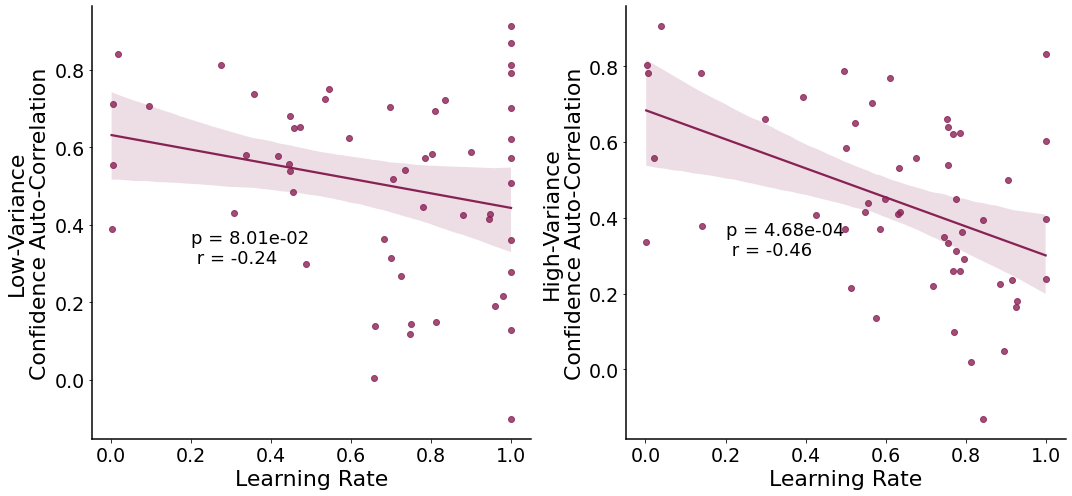

In [8]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_autocorrelation(data, subjects):
    autocorrelations, lags, subject_cl = [], [], []
    for sub in subjects:
        subject_data = data[data["sub"] == sub]
        acf = sm.tsa.acf(subject_data["cj"], fft=True)  # Added fft=True for efficiency
        autocorrelations.extend(acf)
        lags.extend(np.arange(len(acf)))
        subject_cl.extend([sub] * len(acf))
    return pd.DataFrame(zip(subject_cl, lags, autocorrelations), columns=["subject", "lags", "acf"])

def plot_autocorrelation(df, backward_df, subplot_title):
    temp_df_lag1 = df[df["lags"] == 1]
    temp_df_merged = pd.merge(temp_df_lag1, backward_df, on="subject")
#     plt.set_title(subplot_title)
    plot_regression_df(temp_df_merged, "alpha", "acf", "#882255", .2, .3, "Learning Rate", subplot_title)

# Calculate autocorrelation for LV and HV data
auto_corr_df_lv = calculate_autocorrelation(lv_induction_data, subjects)
auto_corr_df_hv = calculate_autocorrelation(hv_induction_data, subjects)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

plt.subplot(1,2,1)
# Plot for LV data
plot_autocorrelation(auto_corr_df_lv, backward_dfs[0], "Low-Variance\nConfidence Auto-Correlation")

plt.subplot(1,2,2)
# Plot for HV data
plot_autocorrelation(auto_corr_df_hv, backward_dfs[1], "High-Variance\nConfidence Auto-Correlation")

fig.tight_layout()
plt.savefig("../figs/Supp_fig4.png", dpi=400, bbox_inches='tight')
plt.show()


## Figure 6

In [9]:
from Forward import simulate_with_params

seed = 1
np.random.seed(seed)
random.seed(seed)

forward_simulation_dfs = []
backward_simulation_dfs = []
for forward_df, data in zip(forward_dfs, data_list):
    forward_simulation_df = simulate_with_params(forward_df, data, subjects , n = 100)
    forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
    forward_simulation_dfs.append(forward_simulation_df)

for backward_df, data in zip(backward_dfs, data_list):
    backward_simulation_df = simulate_with_params(backward_df, data, subjects, n= 100)
    backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
    backward_simulation_dfs.append(backward_simulation_df)

In [10]:
def calculate_avg_and_merge(simulation_dfs, data_list, merge_on="subject"):
    avg_dfs = []
    for sim_df, emp_data in zip(simulation_dfs,data_list):
        emp_data = emp_data.rename(columns = {"sub": "subject"})
        avg_df = sim_df.groupby(merge_on).agg(mean_reward=("reward", "mean"), 
                                               accuracy=("cor", "mean"), 
                                               mean_conf=("cj", "mean")).reset_index()
        
        emp_avg_df = emp_data.groupby(merge_on).agg(mean_reward_emp=("reward", "mean"), 
                                                    accuracy_emp=("cor", "mean"), 
                                                    mean_conf_emp=("cj", "mean")).reset_index()
                
        # Merge with empirical data and calculate difference or ratio
        merged_df = pd.merge(avg_df, emp_avg_df, on=merge_on)
        avg_dfs.append(merged_df)
        groups = ["lv_induction", "hv_induction"]
        df = merge_result_df(avg_dfs, groups, 200, subjects)
    return df

forward_avg_dfs = calculate_avg_and_merge(forward_simulation_dfs, data_list)
backward_avg_dfs = calculate_avg_and_merge(backward_simulation_dfs, data_list)

In [11]:
dfs = []
for backward_simulation_df, forward_simulation_df in zip(
    backward_simulation_dfs, forward_simulation_dfs
):
    backward_avg_df = (
        backward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    forward_avg_df = (
        forward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    backward_avg_df.rename(
        columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
        inplace=True,
    )
    backward_avg_df = pd.merge(backward_avg_df, forward_avg_df, on=["subject"])

    backward_avg_df["mrl_ratio"] = backward_avg_df["accuracy"] / backward_avg_df["cor"]
    dfs.append(backward_avg_df)

groups = ["lv_induction", "hv_induction"]
mrl_df = merge_result_df(dfs, groups, 200, subjects)

[0 1 2]
Statistics=125.0, p=1.05588169887459e-07
Emprical Low-var = 0.86
Emprical High-var = 0.78
Statistics=57.0, p=3.5845890902721695e-09
Forward Low-var = 0.76
Forward High-var = 0.68
Statistics=194.0, p=2.3272879858407235e-06
Backward Low-var = 0.71
Backward High-var = 0.64
Statistics=632.0, p=0.3413865997350308
MetRL Low-var = 0.94
MetRL High-var = 0.95
Empirical Low-var = 3.98
Empirical High-var = 3.79
Statistics=400.0, p=0.003188043227642762
Forward Low-var = 3.99
Forward High-var = 3.83
Statistics=443.0, p=0.009915556661071844
Backward Low-var = 3.99
Backward High-var = 3.80
Statistics=438.0, p=0.008746382294012317


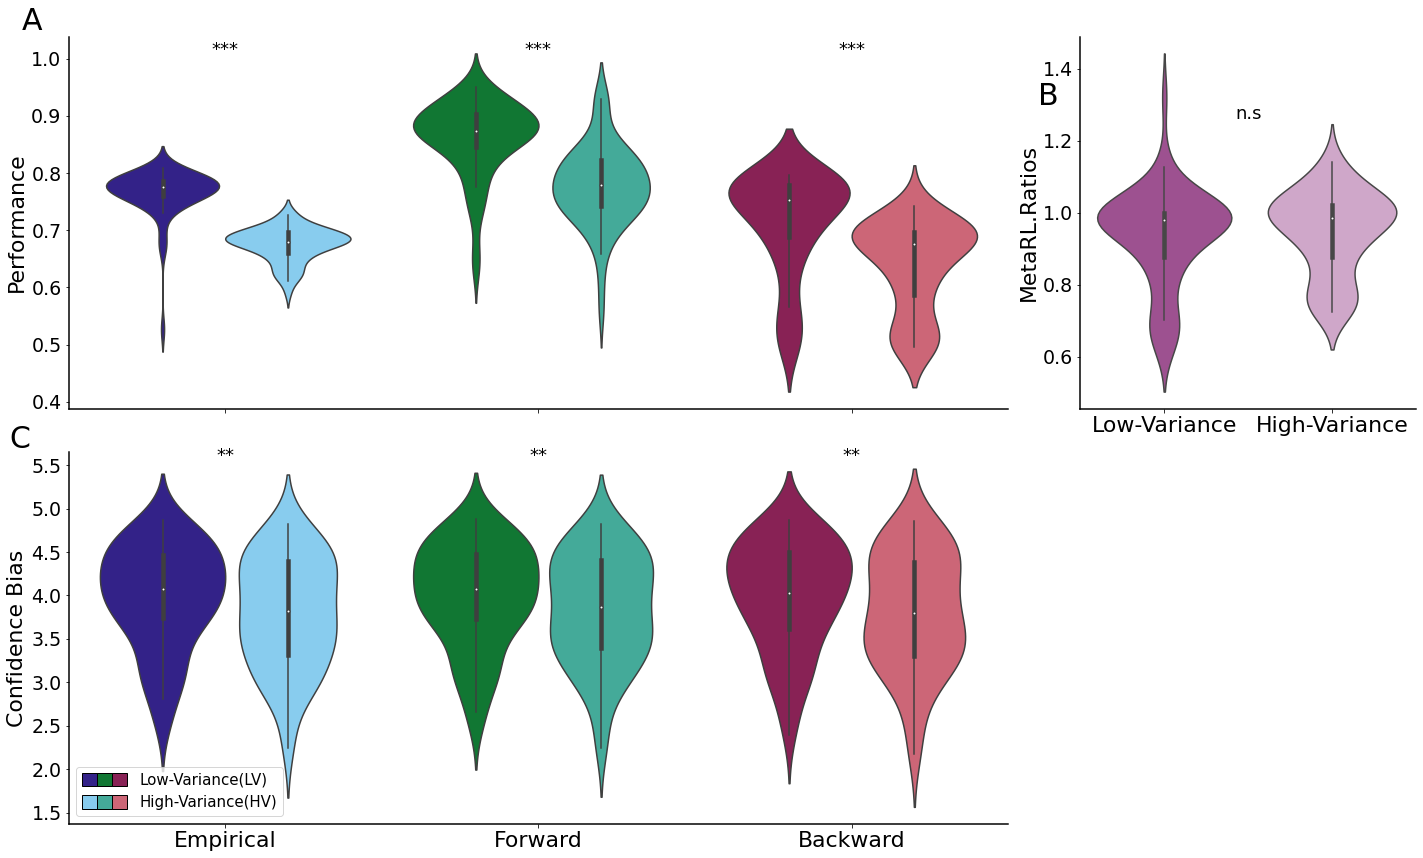

In [12]:
f, ((a0, a1), (a2, a3)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [2.8, 1]}, figsize=(20, 12))

gr1 = "lv_induction"
gr2 = "hv_induction"

from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

colors = [ "#332288", "#88CCEE", "#117733", "#44AA99", "#882255", "#CC6677"]

emp_df = forward_avg_dfs[["subject", "accuracy_emp", "model"]]
emp_df = emp_df.rename(columns= {"model": "task", "accuracy_emp": "Performance"})
emp_df["model"] = "Empirical"

fwd_df = forward_avg_dfs[["subject", "accuracy", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task", "accuracy": "Performance"})
fwd_df["model"] = "Forward"


bck_df = backward_avg_dfs[["subject", "accuracy", "model"]]
bck_df = bck_df.rename(columns= {"model": "task", "accuracy": "Performance"})
bck_df["model"] = "Backward"

violin_df = pd.concat([ fwd_df, emp_df, bck_df])


ax = seaborn.violinplot(data=violin_df, x="model", y="Performance", hue = "task", ax= a0)

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)

handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

# ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
#          , loc = "lower left")

ax.get_legend().remove()


for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=19)

print(ax.get_xticks())

ax.set_xticklabels([])

ax.set_ylabel("Performance", fontsize=22)
ax.set_xlabel("", fontsize=27)


gr1_data = emp_df.query("task=='{}'".format(gr1))
gr2_data = emp_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["Performance"]), np.array(gr2_data["Performance"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

print("Emprical Low-var = {:.2f}".format(gr1_data["Performance"].mean()))
print("Emprical High-var = {:.2f}".format(gr2_data["Performance"].mean()))


ax.text( 1, 1.0,symb , ha='center', va='bottom', fontsize=18)

ax.text(-.65, 1.05, "A", fontsize=30)


gr1_data = fwd_df.query("task=='{}'".format(gr1))
gr2_data = fwd_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["Performance"]), np.array(gr2_data["Performance"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

print("Forward Low-var = {:.2f}".format(gr1_data["Performance"].mean()))
print("Forward High-var = {:.2f}".format(gr2_data["Performance"].mean()))


ax.text( 0, 1.0,symb , ha='center', va='bottom', fontsize=18)

gr1_data = bck_df.query("task=='{}'".format(gr1))
gr2_data = bck_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["Performance"]), np.array(gr2_data["Performance"]))


print('Statistics={}, p={}'.format(stat, p))

print("Backward Low-var = {:.2f}".format(gr1_data["Performance"].mean()))
print("Backward High-var = {:.2f}".format(gr2_data["Performance"].mean()))

symb = pval_symb(p)

ax.text( 2, 1.0,symb , ha='center', va='bottom', fontsize=18)

colors = ["#AA4499", "#D6A0CD"]


ax = seaborn.violinplot(data=mrl_df, x="model", y="mrl_ratio", palette= colors, ax = a1)

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=19)

ax.set_xticklabels(["Low-Variance", "High-Variance"])

ax.set_ylabel("MetaRL.Ratios", fontsize=22)
ax.set_xlabel("", fontsize=25)


gr1_data = mrl_df.query("model=='{}'".format(gr1))
gr2_data = mrl_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["mrl_ratio"]), np.array(gr2_data["mrl_ratio"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

print("MetRL Low-var = {:.2f}".format(gr1_data["mrl_ratio"].mean()))
print("MetRL High-var = {:.2f}".format(gr2_data["mrl_ratio"].mean()))

ax.text( .5, 1.25,symb , ha='center', va='bottom', fontsize=18)
ax.text(-.75, 1.3, "B", fontsize=30)


y_columns = "Conf"
colors = [ "#332288", "#88CCEE", "#117733", "#44AA99", "#882255", "#CC6677"]

emp_df = forward_avg_dfs[["subject", "mean_conf_emp", "model"]]
emp_df = emp_df.rename(columns= {"model": "task", "mean_conf_emp": y_columns})
emp_df["model"] = "Empirical"

fwd_df = forward_avg_dfs[["subject", "mean_conf", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task", "mean_conf": y_columns})
fwd_df["model"] = "Forward"


bck_df = backward_avg_dfs[["subject", "mean_conf", "model"]]
bck_df = bck_df.rename(columns= {"model": "task", "mean_conf": y_columns})
bck_df["model"] = "Backward"

violin_df = pd.concat([emp_df, fwd_df, bck_df])


ax = seaborn.violinplot(data=violin_df, x="model", y= y_columns, hue = "task" , ax = a2)

# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance(LV)", "High-Variance(HV)"], handlelength=3, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower left")


for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=19)

ax.set_xticklabels(["Empirical", "Forward", "Backward"])

ax.set_ylabel("Confidence Bias", fontsize=22)
ax.set_xlabel("", fontsize=25)


gr1_data = emp_df.query("task=='{}'".format(gr1))
gr2_data = emp_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print("Empirical Low-var = {:.2f}".format(gr1_data[y_columns].mean()))
print("Empirical High-var = {:.2f}".format(gr2_data[y_columns].mean()))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

ax.text( 0, 5.5,symb , ha='center', va='bottom', fontsize=18)

gr1_data = fwd_df.query("task=='{}'".format(gr1))
gr2_data = fwd_df.query("task=='{}'".format(gr2))

print("Forward Low-var = {:.2f}".format(gr1_data[y_columns].mean()))
print("Forward High-var = {:.2f}".format(gr2_data[y_columns].mean()))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

ax.text( 1, 5.5,symb , ha='center', va='bottom', fontsize=18)

gr1_data = bck_df.query("task=='{}'".format(gr1))
gr2_data = bck_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_columns]), np.array(gr2_data[y_columns]))

print("Backward Low-var = {:.2f}".format(gr1_data[y_columns].mean()))
print("Backward High-var = {:.2f}".format(gr2_data[y_columns].mean()))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

ax.text( 2, 5.5,symb , ha='center', va='bottom', fontsize=18)
ax.text(-.69, 5.7, "C", fontsize=30)



a3.axis("off")

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/fig6.svg", dpi=400, bbox_inches='tight')

# plt.show()

# new Supplementary Plot

In [13]:
def plot_regression_df(x, y, color, pos_x, pos_y, xlabel, ylabel, stat_fwd_lr, pval):
#     res = scipy.stats.pearsonr(x, y)

#     stat_fwd_lr, pval= res 
#     r_low, r_high = res.confidence_interval(.95)
    
#     print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat_fwd_lr,r_low,r_high))

    seaborn.regplot(x=x, y=y, color= color, label= "Forwarad Model")

    plt.ylabel(ylabel, fontsize=22)
    plt.xlabel(xlabel, fontsize=22)

    ax = plt.gca()
    # hide x-axis
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    plt.text(pos_x, pos_y, "p = {:.2e} \n r = {:.2f}".format(pval, stat_fwd_lr), fontsize=18)
    

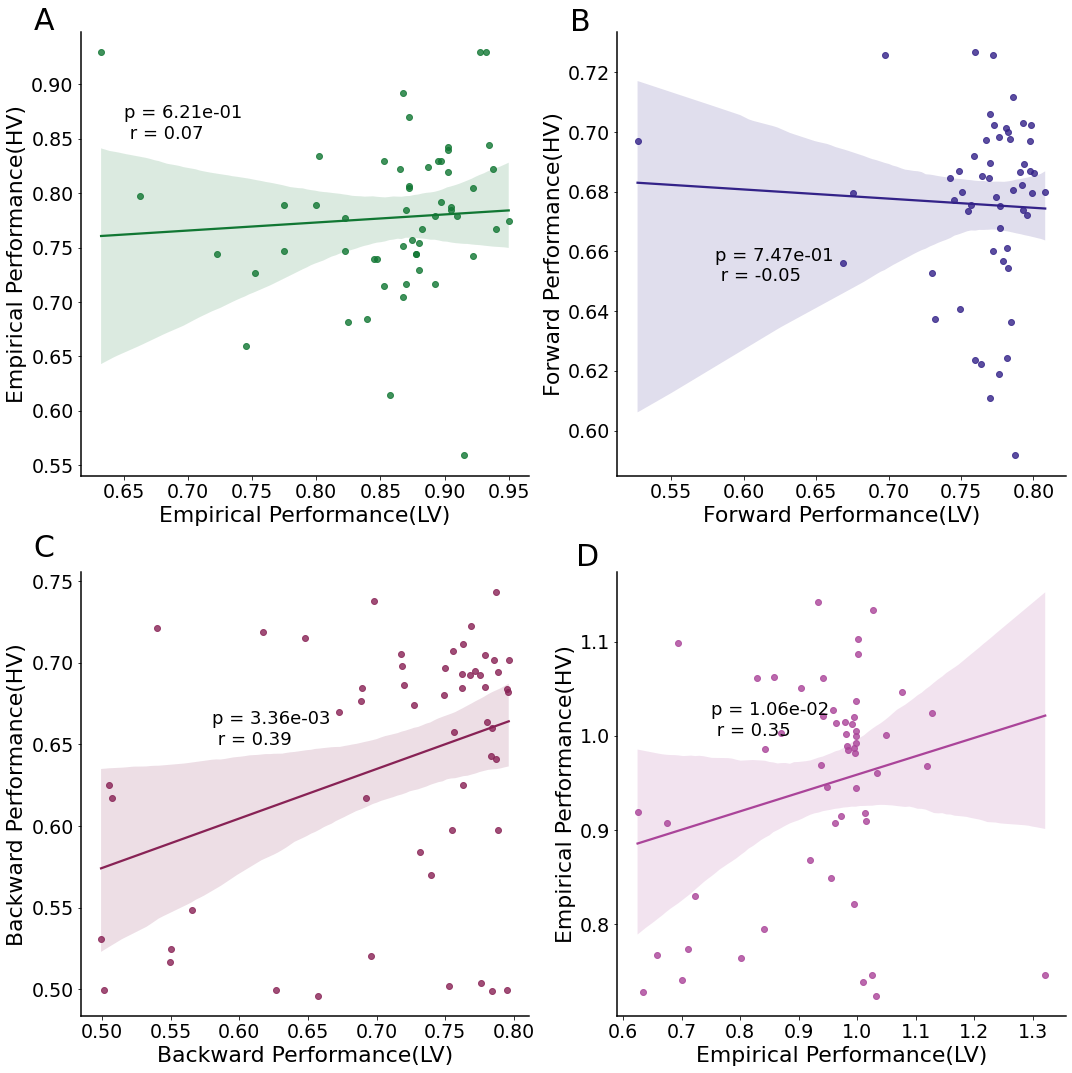

In [43]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plt.text(.58, 0.95, "A", fontsize=30)

emp_df = forward_avg_dfs[["subject", "accuracy_emp", "model"]]
emp_df = emp_df.rename(columns= {"model": "task", "accuracy_emp": "Performance"})
emp_df["model"] = "Empirical"

plot_regression_df(emp_df[emp_df["task"]=="lv_induction"]["Performance"],
                   emp_df[emp_df["task"]=="hv_induction"]["Performance"],
                   "#117733",0.65, .85, "Empirical Performance(LV)", "Empirical Performance(HV)",
                  0.07, 6.21e-1)

plt.subplot(2,2,2)
plt.text(.48, 0.734, "B", fontsize=30)

fwd_df = forward_avg_dfs[["subject", "accuracy", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task", "accuracy": "Performance"})
fwd_df["model"] = "Forward"

plot_regression_df(fwd_df[fwd_df["task"]=="lv_induction"]["Performance"],
                   fwd_df[fwd_df["task"]=="hv_induction"]["Performance"],
                   "#332288",0.58, .65, "Forward Performance(LV)", "Forward Performance(HV)",
                   -0.05, 7.47e-1
                  )

plt.subplot(2,2,3)
plt.text(.45, 0.765, "C", fontsize=30)

bck_df = backward_avg_dfs[["subject", "accuracy", "model"]]
bck_df = bck_df.rename(columns= {"model": "task", "accuracy": "Performance"})
bck_df["model"] = "Backward"

plot_regression_df(bck_df[bck_df["task"]=="lv_induction"]["Performance"],
                   bck_df[bck_df["task"]=="hv_induction"]["Performance"],
                   "#882255",0.58, .65, "Backward Performance(LV)", "Backward Performance(HV)",
                  0.39, 3.36e-03)

plt.subplot(2,2,4)
plt.text(.52, 1.18, "D", fontsize=30)

plot_regression_df(mrl_df[mrl_df["model"]=="lv_induction"]["mrl_ratio"],
                   mrl_df[mrl_df["model"]=="hv_induction"]["mrl_ratio"],
                   "#AA4499",.75, 1, "Empirical Performance(LV)", "Empirical Performance(HV)",
                  0.35, 1.06e-02)

plt.tight_layout()
plt.savefig("../figs/Table1.png", dpi=400, bbox_inches='tight')



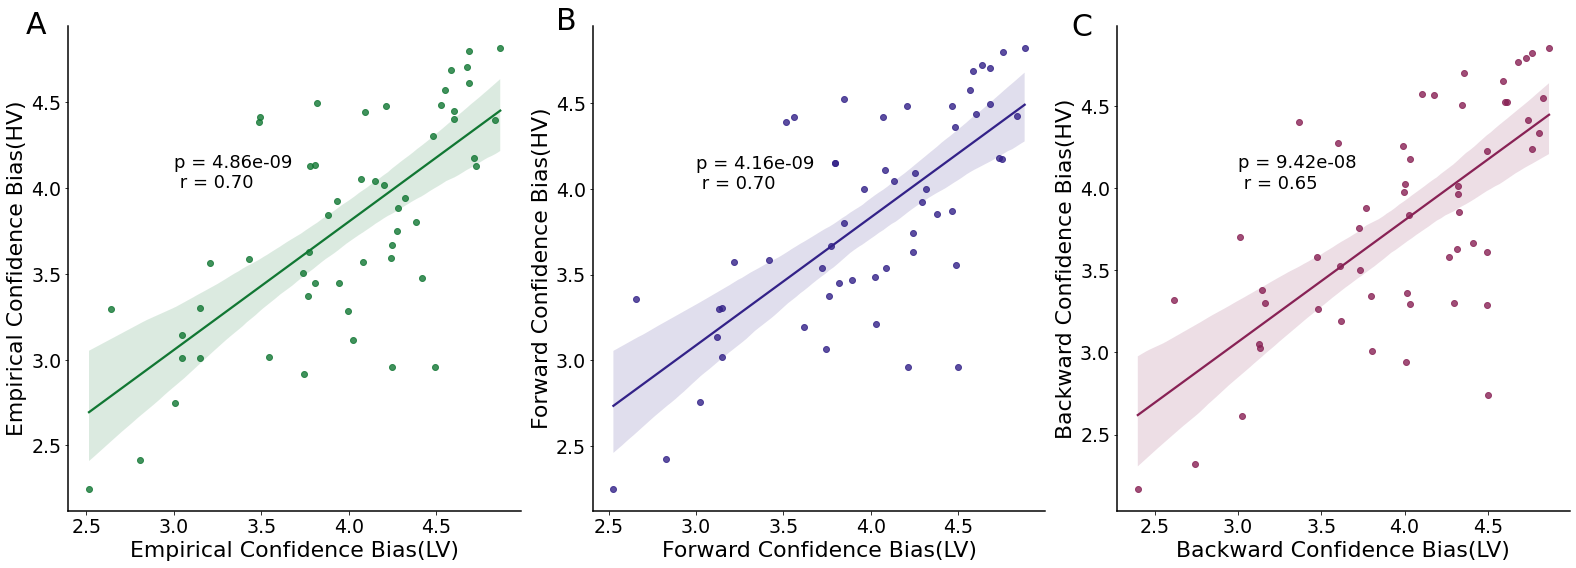

In [59]:
plt.figure(figsize=(22, 8))

emp_df = forward_avg_dfs[["subject", "mean_conf_emp", "model"]]
emp_df = emp_df.rename(columns= {"model": "task", "mean_conf_emp": y_columns})
emp_df["model"] = "Empirical"

fwd_df = forward_avg_dfs[["subject", "mean_conf", "model"]]
fwd_df = fwd_df.rename(columns= {"model": "task", "mean_conf": y_columns})
fwd_df["model"] = "Forward"


bck_df = backward_avg_dfs[["subject", "mean_conf", "model"]]
bck_df = bck_df.rename(columns= {"model": "task", "mean_conf": y_columns})
bck_df["model"] = "Backward"


plt.subplot(1,3,1)
plt.text(2.15, 4.9, "A", fontsize=30)

plot_regression_df(emp_df[emp_df["task"]=="lv_induction"]["Conf"],
                   emp_df[emp_df["task"]=="hv_induction"]["Conf"],
                   "#117733",3, 4, "Empirical Confidence Bias(LV)", "Empirical Confidence Bias(HV)",
                  0.7, 4.86e-9)

plt.subplot(1,3,2)
plt.text(2.2, 4.93, "B", fontsize=30)


plot_regression_df(fwd_df[fwd_df["task"]=="lv_induction"]["Conf"],
                   fwd_df[fwd_df["task"]=="hv_induction"]["Conf"],
                   "#332288",3, 4, "Forward Confidence Bias(LV)", "Forward Confidence Bias(HV)",
                   0.70, 4.16e-9)

plt.subplot(1,3,3)
plt.text(2, 4.93, "C", fontsize=30)


plot_regression_df(bck_df[bck_df["task"]=="lv_induction"]["Conf"],
                   bck_df[bck_df["task"]=="hv_induction"]["Conf"],
                   "#882255",3, 4, "Backward Confidence Bias(LV)", "Backward Confidence Bias(HV)",
                  0.65, 9.42e-08)


plt.tight_layout()
plt.savefig("../figs/Table2.png", dpi=400, bbox_inches='tight')


## Figure 7 

In [93]:
groups = ["lv_induction", "hv_induction"]
forward_params_df = merge_result_df(forward_dfs, groups, 200, subjects)
backward_params_df = merge_result_df(backward_dfs, groups, 200, subjects)

In [94]:
import pandas as pd

model_renames = {
    "lv_induction": "lv_inuction",  # Correcting potential typo: inuction -> induction
    "hv_induction": "hv_inuction"
}

# Function to update model names and assign tasks
def update_models_and_tasks(df, model_prefix):
    for original, new in model_renames.items():
        new_model_name = f"{model_prefix}_{new}"
        df.loc[df["model"] == original, "model"] = new_model_name
        df.loc[df["model"] == new_model_name, "task"] = new
    
    df["model"] = model_prefix
    return df

forward_params_df = update_models_and_tasks(forward_params_df, "forward")
backward_params_df = update_models_and_tasks(backward_params_df, "backward")

# Combine DataFrames and set x_idx
combined_df = pd.concat([forward_params_df, backward_params_df], ignore_index=True)

# Assign x indexes based on unique subjects and gap calculation
subj_to_idx = {subj: idx * 200 for idx, subj in enumerate(sorted(combined_df["subject"].unique()), 1)}
combined_df["x_idx"] = combined_df["subject"].map(subj_to_idx)

# Assuming 'dataframes' is a list of DataFrames to be concatenated and processed
params_df = pd.concat([forward_params_df, backward_params_df], ignore_index=True)



Forward Low-var = 0.94
Forward High-var = 0.89
Statistics=288.0, p=0.04091907995939848
Backward Low-var = 0.67
Backward High-var = 0.63
Statistics=612.0, p=0.483157876473966
Statistics=166.0, p=6.913045006177087e-07
Forward Low-var = 15.15
Forward High-var = 10.23
Statistics=383.0, p=0.003244774476050711
Backward Low-var = 24.96
Backward High-var = 20.68


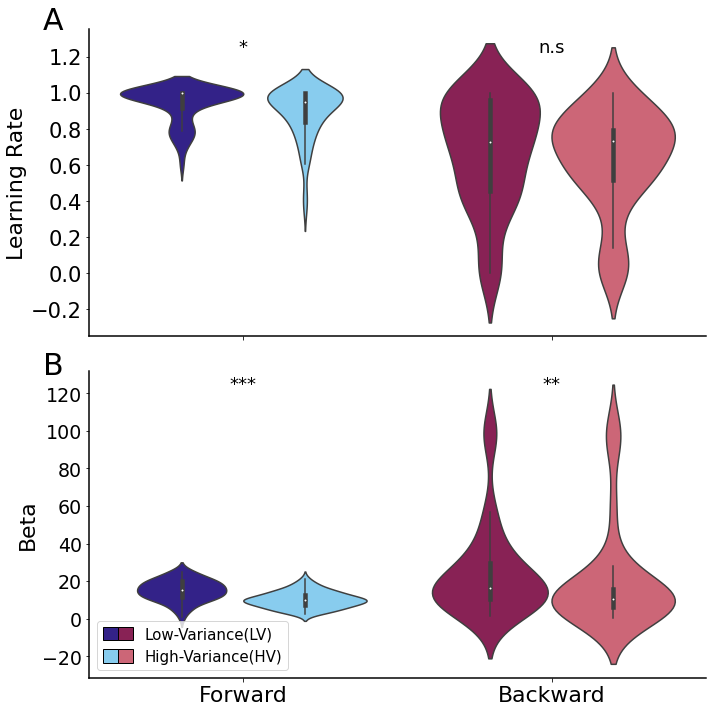

In [97]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)

gr1 = "lv_inuction"
gr2 = "hv_inuction"

from seaborn import violinplot
from matplotlib.collections import PolyCollection

from matplotlib.legend_handler import HandlerTuple

colors = [ "#332288", "#88CCEE", "#882255", "#CC6677"]


ax = seaborn.violinplot(data=params_df, x="model", y="alpha", hue = "task")

ax.text(-.65, 1.35, "A", fontsize=30)


# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

# ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance", "High-Variance"], handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
#          , loc = "lower left")

ax.get_legend().remove()

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=22)
plt.yticks(fontsize=21)

ax.set_xticklabels([])

plt.ylabel("Learning Rate", fontsize=22)
plt.xlabel("", fontsize=25)



gr1_data = forward_params_df.query("task=='{}'".format(gr1))
gr2_data = forward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["alpha"]), np.array(gr2_data["alpha"]))

print("Forward Low-var = {:.2f}".format(gr1_data["alpha"].mean()))
print("Forward High-var = {:.2f}".format(gr2_data["alpha"].mean()))


print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 0, 1.2,symb , ha='center', va='bottom', fontsize=18)

gr1_data = backward_params_df.query("task=='{}'".format(gr1))
gr2_data = backward_params_df.query("task=='{}'".format(gr2))

print("Backward Low-var = {:.2f}".format(gr1_data["alpha"].mean()))
print("Backward High-var = {:.2f}".format(gr2_data["alpha"].mean()))


stat, p = scipy.stats.wilcoxon(np.array(gr1_data["alpha"]), np.array(gr2_data["alpha"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

plt.text( 1, 1.2,symb , ha='center', va='bottom', fontsize=18)


plt.subplot(2,1,2)


ax = seaborn.violinplot(data=params_df, x="model", y="beta", hue = "task")

ax.text(-.65, 130, "B", fontsize=30)


# for pc, color in zip(plots['bodies'], colors):
#     pc.set_facecolor(color)
handles = []

for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin.set_facecolor(colors[ind])
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=colors[ind], edgecolor='black'))

ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Low-Variance(LV)", "High-Variance(HV)"], handlelength=2, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower left")

ax.get_legend()

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=22)
plt.yticks(fontsize=19)

ax.set_xticklabels(["Forward", "Backward"])

plt.ylabel("Beta", fontsize=22)
plt.xlabel("", fontsize=22)



gr1_data = forward_params_df.query("task=='{}'".format(gr1))
gr2_data = forward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["beta"]), np.array(gr2_data["beta"]))

print('Statistics={}, p={}'.format(stat, p))
print("Forward Low-var = {:.2f}".format(gr1_data["beta"].mean()))
print("Forward High-var = {:.2f}".format(gr2_data["beta"].mean()))

symb = pval_symb(p)

plt.text( 0, 120,symb , ha='center', va='bottom', fontsize=18)

gr1_data = backward_params_df.query("task=='{}'".format(gr1))
gr2_data = backward_params_df.query("task=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["beta"]), np.array(gr2_data["beta"]))

print('Statistics={}, p={}'.format(stat, p))
symb = pval_symb(p)

print("Backward Low-var = {:.2f}".format(gr1_data["beta"].mean()))
print("Backward High-var = {:.2f}".format(gr2_data["beta"].mean()))

plt.text( 1, 120,symb , ha='center', va='bottom', fontsize=18)


plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig("../figs/fig7.svg", dpi=400, bbox_inches='tight')
